In [9]:
import numpy as np
import cv2
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import pickle

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)

flower_images_dict = {
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'roses': list(data_dir.glob('roses/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*'))
}
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}

In [27]:
X, y = [], []

for flower_name, images  in flower_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [28]:
# for convinience lets convert X, y into numpy arrays
X = np.array(X)
y = np.array(y)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [30]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [10]:
import tensorflow_hub as hub
import PIL.Image as Image
import os
import matplotlib.pylab as plt

In [11]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

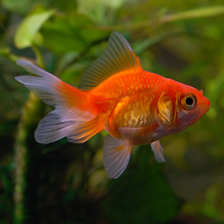

In [13]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [15]:
gold_fish = np.array(gold_fish)/255

In [18]:
y_pred = classifier.predict(gold_fish[np.newaxis, ...])

1/1 [==============================] - 0s 56ms/step


In [21]:
result = np.argmax(y_pred)

In [20]:
image_labels = []
with open('labels.txt','r') as f:
  image_labels = f.read().splitlines()

In [22]:
image_labels[result]

'goldfish'

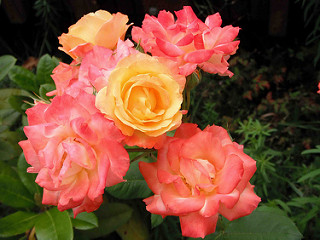

In [25]:
Image.open(str(flower_images_dict['roses'][1]))

In [35]:
y_pred = classifier.predict(np.array([X[0],X[1],X[2]]))

1/1 [==============================] - 0s 127ms/step


In [37]:
predictions = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
[image_labels[predictions[i]] for i in range(len(predictions))]

['shower curtain', 'spotlight', 'pillow']

In [38]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [39]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224,224,3), trainable=False
)

In [40]:
num_of_flowers = 5
model = Sequential([
    pretrained_model_without_top_layer,
    layers.Dense(num_of_flowers)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 82s 911ms/step - loss: 0.7938 - acc: 0.7148
Epoch 2/5
86/86 [==============================] - 76s 880ms/step - loss: 0.4113 - acc: 0.8605
Epoch 3/5
86/86 [==============================] - 77s 900ms/step - loss: 0.3233 - acc: 0.8968
Epoch 4/5
86/86 [==============================] - 76s 880ms/step - loss: 0.2641 - acc: 0.9175
Epoch 5/5
86/86 [==============================] - 77s 897ms/step - loss: 0.2253 - acc: 0.9350


In [42]:
with open("TL_model.pickle","wb") as f:
  pickle.dump(model,f)